# Introduction

This is a tutorial for [PyMVPAw](https://github.com/rystoli/PyMVPAw).

Note: does not run on my github, as I have yet to set up with a public dataset.

To understand and use this, please be familiar with [PyMVPA](http://www.pymvpa.org/). At the current state, this wrapper is untested, though it largely calls and streamlines already tested PyMVPA code minus advanced functions. Therefore please understand PyMVPA, and look at PyMVPAw code yourself before publishing with it.

Best prerequisites are these PyMVPA tutorial chapters:
- [Datasets basics and concepts](http://www.pymvpa.org/tutorial_datasets.html)
- [Getting data in shape](http://www.pymvpa.org/tutorial_mappers.html)
- [Classifiers](http://www.pymvpa.org/tutorial_classifiers.html)
- [Searchlights](http://www.pymvpa.org/tutorial_searchlight.html)

---
# PyMVPAw structure

PyMVPAw wrapper functions are organized into several key script files:
- **datamanage.py** - etc. functions for handling datasets (e.g., saving, masking, printing attributes to CSV, making ROI masks, and more)
- **searchlight_wraps.py** - wrapper functions performing searchlights with various methods (classification, RSA, and our additional RSA methods)
- **roi_wraps.py** - wrapper functions performing various methods on specified ROI via ROI mask (classificaiton, RSA, our additional RSA methods)

We should likely make an easy directory in PyMVPAw to print out functions and their purpose, but you'll find them relatively easy to navigate within the [Python files](https://github.com/rystoli/RyMVPA/tree/master/rymvpa). There are according prefixes to all searchlight ('sl') and ROI ('roi') functions, so you can tab out from those to quickly see options. As well, use Python's help function on any PyMVPAw method to see documentation.  

Let's import PyMVPAw and its dependencies, and take a look at a function's doc:

In [2]:
%matplotlib inline
from pymvpaw import *

help(slRSA_m_nSs)

Help on function slRSA_m_nSs in module rymvpa.searchlight_wraps:

slRSA_m_nSs(data, model, radius=3, partial_dsm=None, control_dsms=None, resid=False, cmetric='pearson', h5=0, h5out='slRSA_m_nSs.hdf5', status_print=1)
    Executes slRSA per subject in datadict (keys=subjIDs), returns dict of avg map fisher Z transformed r's and 1-p's per voxel arrays
    
    data: dictionary of pymvpa dsets per subj, indices being subjIDs
    model: model DSM to be correlated with neural DSMs per searchlight center
    partial_dsm: model DSM to be partialled out of model-neural DSM correlation
    control_dsms: list of DSMs to be controlled for in multiple regression 
                  which returns r of model DM predictor (converted from beta)                  
    resid: Default False. Set to True to return residual to searchlight center
    radius: sl radius, default 3
    cmetric: default pearson, other optin 'spearman'
    h5: 1 if you want to save hdf5 as well
    h5out: hdf5 outfilename



Various other unique called by these wrappers are in the various other Python files, such as unique similarity analysis algorithms (e.g., multiple regression RSA), partitioners (e.g., that allow us to train on certain targets, test on others), and permutation testing algorithms. Please browse them to find these functions documented, or contact me with questions. I would recommend scanning the files to get a picture of what we have already created. Or, I'd appreciate help making better documentation (and testing ;). 

---
# Setting up

Next, we load the data in the form of a 'data dictionary' or 'datadict'. The datadict is the current convenient way PyMVPAw holds and works on datasets with multiple subjects. Each key is the subject ID, each value is the PyMVPA dataset with attributes loaded in. 

In this example, and my work so far, once we create each PyMVPA dataset per subject (including the loading of attributes), we save them into an H5 object that can be readily loaded to analyze data. H5 files are merely any python object saved as a hard file that can be loaded back into python.

*This is memory inefficient, as it's holding each subject in in memory, and should be reprogrammed to load one at a time.*

In [13]:
data = h5load('brc_allsubjs_tcm.gzipped.hdf5')

In [6]:
print("'Data' type:",type(data))
print('Subject IDs:',data.keys())
print('Subject 544',type(data['544']))

("'Data' type:", <type 'dict'>)
('Subject IDs:', ['559', '558', '572', '571', '570', '551', '550', '553', '552', '542', '543', '540', '541', '547', '544', '545', '548', '549', '557', '568', '569', '556', '560', '561', '562', '563', '564', '565', '566'])
('Subject 544', <class 'mvpa2.datasets.base.Dataset'>)


As we will see, each dataset is pre-prepared with sample attributes:

In [7]:
ds = data['559'].copy() #create temp dataset to look at; hard copy so it doesnt alter original!
print(ds.summary())

Dataset: 39x74455@float32, <sa: chunks,targets,time_coords,time_indices>, <fa: voxel_indices>, <a: imghdr,imgtype,mapper,subjID,task,voxel_dim,voxel_eldim>
stats: mean=8.37888e-09 std=0.995036 var=0.990097 min=-3.35831 max=3.35829

Counts of targets in each chunk:
  chunks\targets  M1  M2  M3  M4  M5  M6  P1  P2  P3  P4  P5  P6  S0
                 --- --- --- --- --- --- --- --- --- --- --- --- ---
       04         1   1   1   1   1   1   1   1   1   1   1   1   1
       05         1   1   1   1   1   1   1   1   1   1   1   1   1
       06         1   1   1   1   1   1   1   1   1   1   1   1   1

Summary for targets across chunks
  targets mean std min max #chunks
    M1      1   0   1   1     3
    M2      1   0   1   1     3
    M3      1   0   1   1     3
    M4      1   0   1   1     3
    M5      1   0   1   1     3
    M6      1   0   1   1     3
    P1      1   0   1   1     3
    P2      1   0   1   1     3
    P3      1   0   1   1     3
    P4      1   0   1   1     3
   

Now, let's take a close look at this dataset. What we see if samples where participants looked at faces varying on a morph continuum between black and white faces, with S0 ('start') referring to the center point, M ('minus') referring to increasingly White faces, P ('plus') to increasingly Black faces. 

That is, the continuum varies from White (-6, or 'M6') to Ambiguous (0, or 'S0') to Black (+6, or 'P6').

Data is chunked by functional runs.

In [8]:
print('Targets:',ds.UT)
print('Chunks:',ds.UC)

('Targets:', array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'P1', 'P2', 'P3', 'P4', 'P5',
       'P6', 'S0'],
      dtype='|S2'))
('Chunks:', array(['04', '05', '06'],
      dtype='|S2'))


Now, let's load in some dissimilarity matrices we can use for RSA analyses, and any other independent data we may want to combine with analyses. You will see, my python file holding this has some functions that print out QA about DMs, and what is being loaded.

In [9]:
import DMs_brc
print('Example DM:',DMs_brc.mlDMstandard['mlDMstandard'])

DSMS qa:

DSM set: 'mlDMstandard'

DSM | Shape | First | Last
mlDMstandard (13, 13) 0 0
('Example DM:', array([[ 0,  1,  2,  3,  4,  5,  2,  3,  4,  5,  6,  7,  1],
       [ 1,  0,  1,  2,  3,  4,  3,  4,  5,  6,  7,  8,  2],
       [ 2,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  3],
       [ 3,  2,  1,  0,  1,  2,  5,  6,  7,  8,  9, 10,  4],
       [ 4,  3,  2,  1,  0,  1,  6,  7,  8,  9, 10, 11,  5],
       [ 5,  4,  3,  2,  1,  0,  7,  8,  9, 10, 11, 12,  6],
       [ 2,  3,  4,  5,  6,  7,  0,  1,  2,  3,  4,  5,  1],
       [ 3,  4,  5,  6,  7,  8,  1,  0,  1,  2,  3,  4,  2],
       [ 4,  5,  6,  7,  8,  9,  2,  1,  0,  1,  2,  3,  3],
       [ 5,  6,  7,  8,  9, 10,  3,  2,  1,  0,  1,  2,  4],
       [ 6,  7,  8,  9, 10, 11,  4,  3,  2,  1,  0,  1,  5],
       [ 7,  8,  9, 10, 11, 12,  5,  4,  3,  2,  1,  0,  6],
       [ 1,  2,  3,  4,  5,  6,  1,  2,  3,  4,  5,  6,  0]]))


Lastly, a note. If all of your data is the same size, you should create a 'remap' dataset, which will be used as formatting to bring any PyMVPA datset back to NIFTI format. These are essential as some functions alter featural aspects of the dataset. A remap dataset should always be the original format the dataset was loaded into PyMVPA as.

In [29]:
remap = ds.copy()

Since our datasets are different sizes (each masked by their own data), we will later use each subject's own data as their remap dataset.

---
# Data management tools

Now that our environment is set up, with our datadict, a remap dataset, and any additional data needed (DMs), we can get started.

First, let's take a look at some essential [data management tools](https://github.com/rystoli/PyMVPAw/blob/master/rymvpa/datamanage.py) available in PyMVPAw.

In [11]:
# Save PyMVPA datasets to nifti files
ds2nifti(data['559'],data['559'],'s559')
import glob
print('Nifti files saved in current directory:',glob.glob('./*nii'))
# also see datadict2nifti for quickly saving a datadict to niftis when shapes match in a dataset

# Select certain targets (remove targets you aren't interested to save memory / aid algorithms)
data_S0 = select_targets_data(data,['S0'])
print('Unique targets across subjects:', np.unique([data_S0[s].UT for s in data_S0]))
del(data_S0)
# also see omit functions, and select chunk functions

# Mask a dataset! ...for some reason, PyMVPA doesn't make code available to do this outside loading a datset with fmri_dataset().
mask = 'tc3_SVM_mask_rFG.nii.gz'
print('Masked ds shape:',mask_dset(ds,mask).shape) # mask of rFG from a group level classification analysis of 3 categories in this dataset

('Nifti files saved in current directory:', ['./s559.nii'])
('Unique targets across subjects:', array(['S0'],
      dtype='|S2'))
('Masked ds shape:', (39, 388))


Make sure to check out other useful functions for saving PyMVPA datasets back to CSVs to analyze data elsewhere, such as clust2mask, sxs2dset, and sa2csv. 

---

# ROI basic analyses

To start with one useful function, what if we wanted to see the neural similarity of each condition? You could then use MDS or other methods to look at the representational geometry of any ROI you specify.

In [116]:
# currently seems to alter data permanently, so, data needs to be reloaded after
print(roi2ndm_1Ss(ds, mask))

[[ 0.          1.25046669  1.23047037  1.21436335  1.196103    0.87472471
   0.81395017  0.95932971  1.07953926  0.8516873   1.14392796  1.04139239
   1.13246263]
 [ 1.25046669  0.          0.76561399  0.80508065  1.16049718  0.78384882
   0.98235361  1.36904629  1.37163041  1.17593324  1.33193249  1.2823674
   0.71330955]
 [ 1.23047037  0.76561399  0.          0.8713607   1.08899694  0.89487072
   1.06397869  1.30106281  1.13931563  1.21229903  1.16848239  1.40283523
   0.79473078]
 [ 1.21436335  0.80508065  0.8713607   0.          0.8935026   0.76568658
   1.06387311  1.29719708  1.03290494  1.48754513  1.19914644  1.50850799
   0.84931425]
 [ 1.196103    1.16049718  1.08899694  0.8935026   0.          1.17427711
   0.97074703  1.11624029  0.88627312  1.26839938  0.97024     0.93520427
   1.30380105]
 [ 0.87472471  0.78384882  0.89487072  0.76568658  1.17427711  0.
   1.01281188  1.21388527  1.21153475  1.05234364  1.41981374  1.49141619
   1.0242347 ]
 [ 0.81395017  0.98235361  1.06

## RSA

What if we wanted to perform RSA in this region, using a basic a priori visual model? 

**Quick note**: you will notice '1' vs. 'n' prefixes for each function in PyMVPAw. '1' applies the analysis to one subject/PyMVPA dataset. 'n' applies the analysis to a datadict.

In [14]:
data = h5load('brc_allsubjs_tcm.gzipped.hdf5') 
res = roiRSA_nSs(data,mask,DMs_brc.mlDMstandard['mlDMstandard'])

roiRSA initiated with...
 Ss: ['559', '558', '572', '571', '570', '551', '550', '553', '552', '542', '543', '540', '541', '547', '544', '545', '548', '549', '557', '568', '569', '556', '560', '561', '562', '563', '564', '565', '566']
roi_mask: tc3_SVM_mask_rFG.nii.gz
h5: 0
h5out: roiRSA_nSs.hdf5
Beginning group level roi analysis on 29 Ss...
\Running roiRSA for subject 559
Dataset masked to shape: (39, 388)
Beginning roiRSA analysis...
\Running roiRSA for subject 558
Dataset masked to shape: (39, 388)
Beginning roiRSA analysis...
\Running roiRSA for subject 572
Dataset masked to shape: (39, 388)
Beginning roiRSA analysis...
\Running roiRSA for subject 571
Dataset masked to shape: (39, 388)
Beginning roiRSA analysis...
\Running roiRSA for subject 570
Dataset masked to shape: (39, 387)
Beginning roiRSA analysis...
\Running roiRSA for subject 551
Dataset masked to shape: (39, 388)
Beginning roiRSA analysis...
\Running roiRSA for subject 550
Dataset masked to shape: (39, 388)
Beginning roi

In [120]:
print res[0]

Ttest_1sampResult(statistic=4.0677031535947163, pvalue=0.00035035764727116796)


Here we see condition similarity is relate to an a priori visual model of the morph levels' similarities. Of course this analysis was circular / based on wholebrain SVM results. Note the documentation for the RSA function, and that you may control for additional DMs in partial correlations or multiple regression as well, for instance, controlling for additional visual models. As well, check documentation for different options, such as distance metrics.

## Classification 

Now let's try classification. First, we will relab anything below the morph center as White, and above as Black.

In [16]:
data_wb = dict([ (s,data[s].copy()) for s in data ] )
for s in data_wb:
    data_wb[s].sa['targets'] = ['w' if i[0] == 'M' else 'b' for i in data_wb[s].targets]
print('New vs. old target labels:')
print data_wb['566'].targets
print data['566'].targets

New vs. old target labels:
['w' 'w' 'w' 'w' 'w' 'w' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'w' 'w' 'w' 'w' 'w'
 'w' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'w' 'w' 'w' 'w' 'w' 'w' 'b' 'b' 'b' 'b'
 'b' 'b' 'b']
['M6' 'M5' 'M4' 'M3' 'M2' 'M1' 'S0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'M6' 'M5'
 'M4' 'M3' 'M2' 'M1' 'S0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'M6' 'M5' 'M4' 'M3'
 'M2' 'M1' 'S0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6']


In [17]:
# to run the classifier
res = roiClass_nSs(data_wb,mask)

roiClass initiated with...
 Ss: ['559', '558', '572', '571', '556', '551', '550', '553', '552', '542', '543', '540', '541', '547', '544', '545', '548', '549', '557', '568', '569', '570', '560', '561', '562', '563', '564', '565', '566']
roi_mask: tc3_SVM_mask_rFG.nii.gz
h5: 0
h5out: roiClass_nSs.hdf5
Beginning group level roi analysis on 29 Ss...
\Running roiClass for subject 559
Dataset masked to shape: (39, 388)
Beginning roiClass analysis w/ targets ['b' 'w']...
\Running roiClass for subject 558
Dataset masked to shape: (39, 388)
Beginning roiClass analysis w/ targets ['b' 'w']...
\Running roiClass for subject 572
Dataset masked to shape: (39, 388)
Beginning roiClass analysis w/ targets ['b' 'w']...
\Running roiClass for subject 571
Dataset masked to shape: (39, 388)
Beginning roiClass analysis w/ targets ['b' 'w']...
\Running roiClass for subject 556
Dataset masked to shape: (39, 388)
Beginning roiClass analysis w/ targets ['b' 'w']...
\Running roiClass for subject 551
Dataset maske

In [152]:
print res[0]
del(data_wb)

Ttest_1sampResult(statistic=3.5963261684239347, pvalue=0.0012260115748790965)


Again, circular, but it works! See documentation for altering parameters, such as cross validation partitioners and classifiers.

---

# Searchlights

Now, to demonstrate these same analyses as searchlights, lets first reduce the dataset size substantially so that we can test this code quickly (searchlights can take substantial time, and I recommend HPC use always to divide subjects up and perform quickly). We'll also only look at a few subjects.

In [18]:
data = h5load('brc_allsubjs_tcm.gzipped.hdf5')
data = dict( [ (s,mask_dset(data[s],mask)) for s in data.keys()[:2]]) #using our mask, so datasets will have only a few hundred searchlight centers


## RSA

First, let's run our RSA model through a searchlight. See function documentation for other options, such as saving options, metrics, multiple regression RSA, etc.

In [19]:
slres = slRSA_m_nSs( data, DMs_brc.mlDMstandard['mlDMstandard'])['r'] #turn off status print to see status, easy to estimate searchlight time to complete with this

Model slRSA initiated with...
 Ss: ['559', '558']
model shape: (13, 13)
radius: 3
h5: 0
h5out: slRSA_m_nSs.hdf5
Beginning group level searchlight on 2 Ss...

Preparing slRSA for subject 559
('Mean group sample computed at size:', (13, 388), '...with UT:', array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'P1', 'P2', 'P3', 'P4', 'P5',
       'P6', 'S0'],
      dtype='|S2'))
Beginning slRSA analysis...
[SLC] DBG:                           Starting computing block for 388 elements
[SLC] DBG:                           +0:00:04 ======[100%]====== 0:00:00  ROI 388 (388/388), 22 features  

[SLC] DBG:                            hstacking 388 results of shape (2, 1)
[SLC] DBG:                            hstacked shape (2, 388)
('slRSA complete with map of shape:', (2, 388), '...p max/min:', 0.67552554522119779, -0.1151460606372528, '...r max/min', 0.99861764238515327, 1.1658930826045289e-11)

Preparing slRSA for subject 558
('Mean group sample computed at size:', (13, 388), '...with UT:', array(['M1'

In [20]:
print('shape',slres['559'].shape)
print('max',np.max(slres['559']))
print('min',np.min(slres['559']))
print('mean',np.mean(slres['559']))
print('sd',np.std(slres['559']))

('shape', (388,))
('max', 0.82083767106698002)
('min', -0.1156590401414998)
('mean', 0.26548664407027633)
('sd', 0.15416998901557016)


We now have a numpy array per datadict key (subject), where each value is the result of the analysis within a searchlight sphere around that voxel center. We may now remap and save these as nifti files, and complete whole-brain analyses in other software such as AFNI. Make sure to see documentation for additional save options, such as datadict saving. 

('Nifti files saved in current directory:', ['./s559.nii', './slRSA_rFG_559.nii', './temp_glass_plot_rymvpa.nii', './temp_plotBrain_rymvpa.nii'])
Plotting unthresholded image


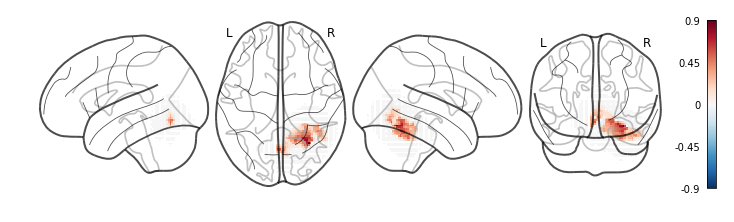

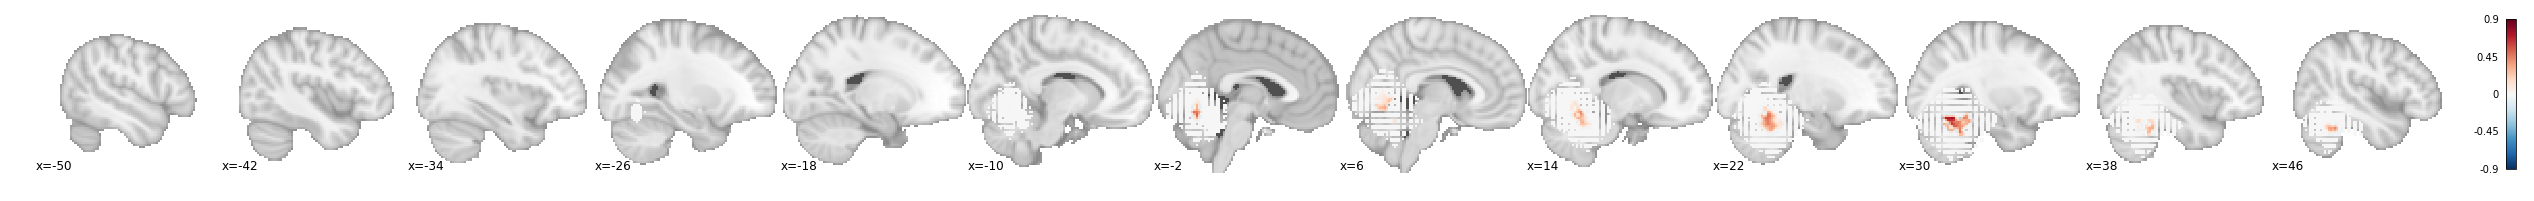

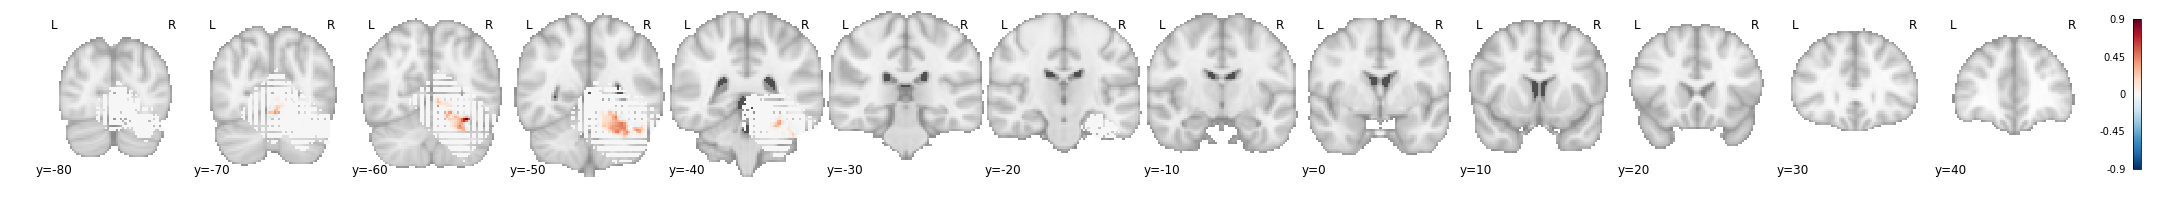

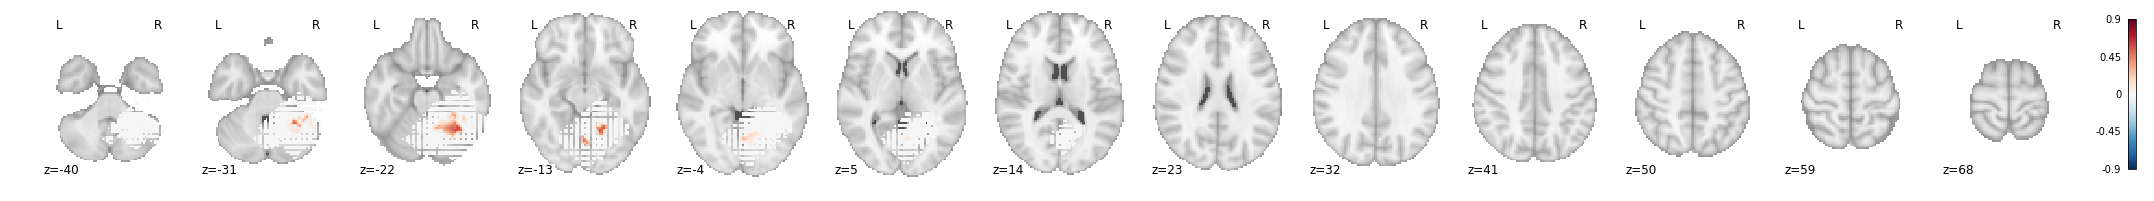

In [36]:
ds2nifti(slres['559'],data['559'],'slRSA_rFG_559.nii')
print('Nifti files saved in current directory:',glob.glob('./*nii'))

plotteRy_Brain('./slRSA_rFG_559.nii')

## Classification

Lastly, let's do classification. Again, check documentation for more options. First, let's relabel again. Then run our datadict searchlight.

In [37]:
data_wb = dict([ (s,data[s].copy()) for s in data ] )
for s in data_wb:
    data_wb[s].sa['targets'] = ['w' if i[0] == 'M' else 'b' for i in data_wb[s].targets]
print('New vs. old target labels:')
print data_wb['559'].targets
print data['559'].targets

New vs. old target labels:
['w' 'w' 'w' 'w' 'w' 'w' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'w' 'w' 'w' 'w' 'w'
 'w' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'w' 'w' 'w' 'w' 'w' 'w' 'b' 'b' 'b' 'b'
 'b' 'b' 'b']
['M6' 'M5' 'M4' 'M3' 'M2' 'M1' 'S0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'M6' 'M5'
 'M4' 'M3' 'M2' 'M1' 'S0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'M6' 'M5' 'M4' 'M3'
 'M2' 'M1' 'S0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6']


In [38]:
slres = slClass_nSs( data_wb )

slClass initiated with...
 Ss: ['559', '558']
radius: 3
h5: 0
h5out: slSVM_nSs.hdf5
Beginning group level searchlight on 2 Ss...
\Running slClass for subject 559
Beginning sl classification analysis...
[SLC] DBG:                           Starting computing block for 388 elements
[SLC] DBG:                           +0:00:16 ======[100%]====== 0:00:00  ROI 388 (388/388), 22 features  

[SLC] DBG:                            hstacking 388 results of shape (3, 1)
[SLC] DBG:                            hstacked shape (3, 388)
\Running slClass for subject 558
Beginning sl classification analysis...
[SLC] DBG:                           Starting computing block for 388 elements
[SLC] DBG:                           +0:00:17 ======[100%]====== 0:00:00  ROI 388 (388/388), 22 features  

[SLC] DBG:                            hstacking 388 results of shape (3, 1)
[SLC] DBG:                            hstacked shape (3, 388)
slClass complete for all subjects


In [39]:
print('shape',slres['559'].shape)
print('max',np.max(slres['559']))
print('min',np.min(slres['559']))
print('mean',np.mean(slres['559']))
print('sd',np.std(slres['559']))

('shape', (1, 388))
('max', 0.29487179487179482)
('min', -0.11538461538461542)
('mean', 0.10415014538725878)
('sd', 0.078293323382827795)


We again now have an array of results per searchlight voxel center. However, this time, they are accuracies subtracting chance level, indicating probability of correct classification compared to chance level. Again, we may save this in various ways for group level significance testing.

('Nifti files saved in current directory:', ['./s559.nii', './slClass_rFG_559.nii', './slRSA_rFG_559.nii', './temp_glass_plot_rymvpa.nii', './temp_plotBrain_rymvpa.nii'])
Plotting unthresholded image


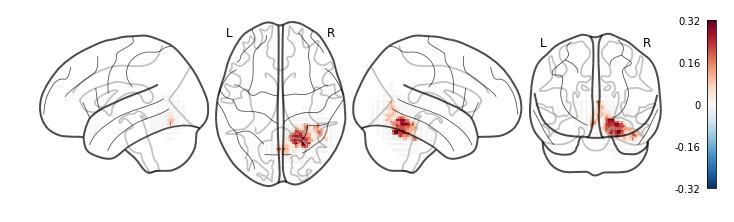

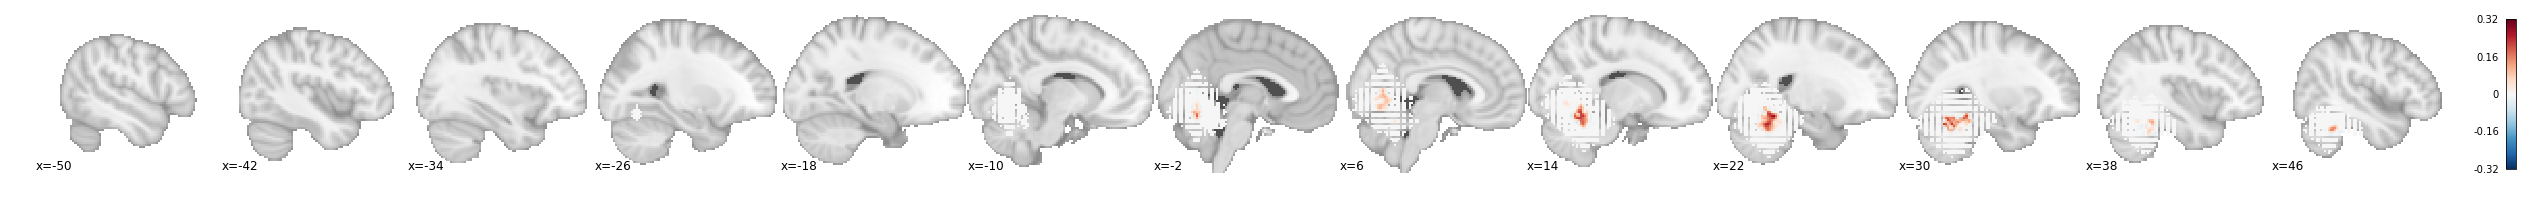

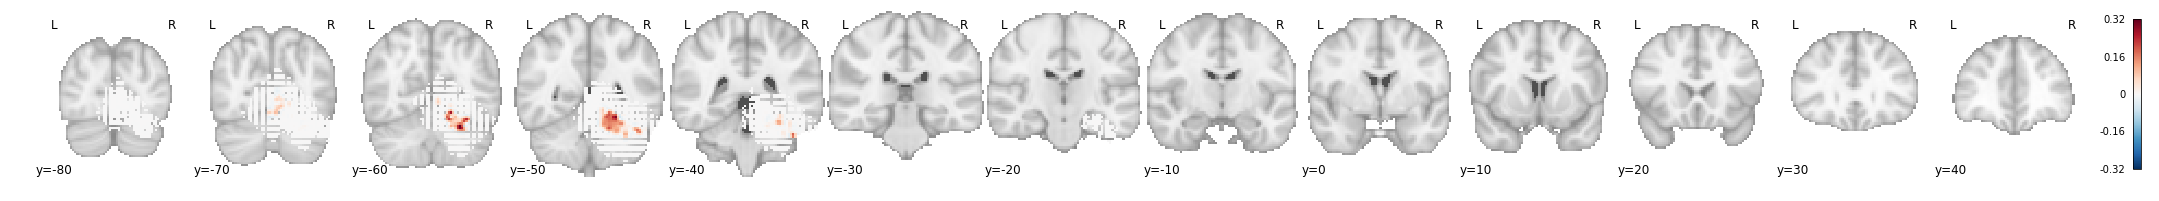

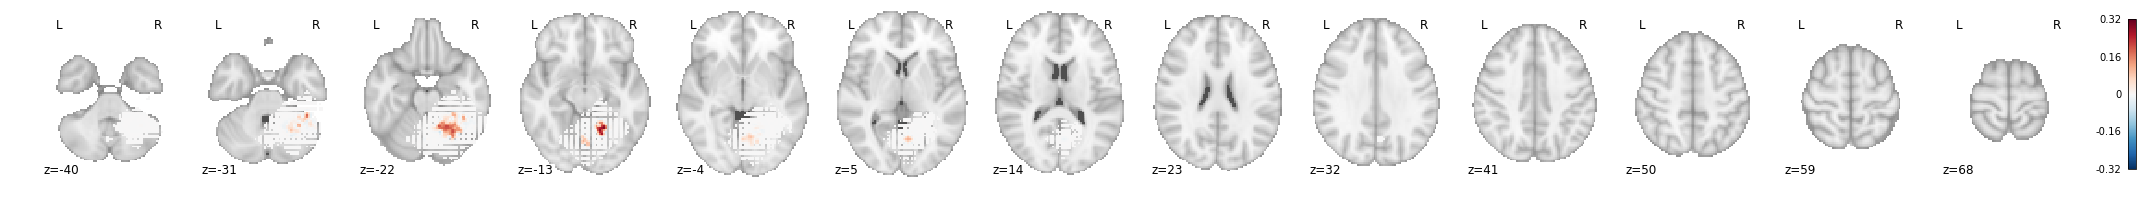

In [40]:
ds2nifti(slres['559'],data['559'],'slClass_rFG_559.nii')
print('Nifti files saved in current directory:',glob.glob('./*nii'))

plotteRy_Brain('./slClass_rFG_559.nii')

---
# Summing up

That is it for the basics. Another tutorial will cover more advanced analyses shortly.